# EDA — Combined Dataset (Strict then Loose)

**Inputs**
- `../data/processed/netflix_strict_clean.csv` (from Notebook 2)
- `../data/processed/netflix_merged_strict_then_loose.csv` (from Notebook 1)

**Goal**
- Start from the *clean strict* set as the gold standard.
- Compare against the *strict+loose* merged set to see if added metadata (director/country/genres) changes patterns.
- Decide which dataset to carry into modeling (regression/classification).

**Notes**
- “Loose” joins (title only) can introduce noise; we’ll inspect deltas and keep safeguards.

## Cleaning & Feature Engineering Plan for Combined Dataset

- Load: `../data/processed/netflix_merged_strict_then_loose.csv`
- Light noise cleanup (e.g., `rating`, `duration`)
- Engineer features:
    - `duration_minutes` (numeric duration)
    - `is_show` (binary flag from type)
    - `is_classic` (release year < 2000)
    - `desc_len` (description length)
    - `num_genres` (count from `listed_in`)
    - `imdb_votes_log1p` (log1p transform of votes)
- Save cleaned dataset to: `../data/processed/netflix_combined_clean.csv`
- Save manifest to: `../data/interim/netflix_combined_manifest.json`

1. Import libraries

In [10]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
from datetime import datetime

2. Paths

In [2]:
PROCESSED_DIR = Path("../data/processed")
INTERIM_DIR   = Path("../data/interim")

STRICT_CLEAN_CSV  = PROCESSED_DIR / "netflix_strict_clean.csv"
COMBINED_RAW_CSV      = PROCESSED_DIR / "netflix_merged_strict_then_loose.csv"
STRICT_MANIFEST   = PROCESSED_DIR / "netflix_strict_clean.manifest.json"

COMBINED_CLEAN_CSV = PROCESSED_DIR / "netflix_combined_clean.csv"
COMBINED_MANIFEST  = INTERIM_DIR / "netflix_combined_manifest.json"

# Create dirs if missing
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

3. Load strict clean

In [3]:
df_strict = pd.read_csv(STRICT_CLEAN_CSV)

4. Load combined (strict + loose). We’ll align columns on the fly when needed.

In [7]:
df_combined_raw = pd.read_csv(COMBINED_RAW_CSV)

5. Print shape for both strict and combined dataframes

In [8]:
print(f"Strict clean shape:   {df_strict.shape}")
print(f"Combined raw shape:   {df_combined_raw.shape}")

Strict clean shape:   (3067, 26)
Combined raw shape:   (5283, 19)


6. Optional: load manifest for quick context

In [11]:
try:
    manifest = json.loads(Path(STRICT_MANIFEST).read_text())
    print("Strict manifest:", manifest["n_rows"], "rows,", manifest["n_cols"], "cols")
except FileNotFoundError:
    print("Manifest not found (ok). Proceeding.")

print("Strict clean shape:", df_strict.shape)
print("Combined raw shape:", df_combined_raw.shape)

Strict manifest: 3067 rows, 26 cols
Strict clean shape: (3067, 26)
Combined raw shape: (5283, 19)


7. Helper cleaners/engineers (reuse the same logic as strict so features are comparable)

In [12]:
def clean_rating_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    # Fix common noise
    replacements = {
        "84 min": "Unknown",  # rating column sometimes polluted by duration text
        "nan": "Unknown",
        "None": "Unknown",
        "": "Unknown"
    }
    return s.replace(replacements)

In [13]:
def parse_duration_minutes(duration_series: pd.Series, fallback_runtime=None) -> pd.Series:
    """
    Parse 'duration' like '92 min' or '3 Seasons' to minutes.
    For seasons/episodes we leave NaN unless a fallback runtime is given.
    """
    s = duration_series.astype(str).str.strip().str.lower()

    # minutes (e.g., '92 min')
    mins = s.str.extract(r'(\d+)\s*min', expand=False).astype(float)

    # seasons/episodes -> NaN (unless you want a mapping)
    # ex: '3 seasons', '8 episodes' -> leave NaN
    # If fallback runtime exists (numeric), we can fill NaN with it
    if fallback_runtime is not None and isinstance(fallback_runtime, pd.Series):
        mins = mins.fillna(fallback_runtime.astype(float))
    return mins

In [14]:
def engineer_common_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Basic safety: ensure expected columns exist (create empty if missing)
    for col in ["description","listed_in","rating","duration","type","release_year","runtime","imdb_votes"]:
        if col not in out.columns:
            out[col] = np.nan

    # Clean rating noise
    out["rating"] = clean_rating_series(out["rating"])

    # Duration minutes
    out["duration_minutes"] = parse_duration_minutes(out["duration"], fallback_runtime=out.get("runtime"))

    # Binary flags
    out["is_show"]    = (out["type"].astype(str).str.upper() == "SHOW").astype(int)
    out["is_classic"] = (out["release_year"].astype(float) < 2000).astype(int)

    # Text signals
    out["desc_len"]  = out["description"].fillna("").str.len()
    out["num_genres"] = out["listed_in"].fillna("").apply(lambda x: len([g.strip() for g in str(x).split(",") if g.strip()]))

    # Votes transform
    out["imdb_votes_log1p"] = np.log1p(out["imdb_votes"])

    # Make a normalized title for joins/diagnostics if needed
    if "title" in out.columns:
        out["title_norm"] = out["title"].astype(str).str.strip().str.lower()

    return out

8. Engineer features on combined (light cleanup + parity with strict)

In [15]:
combined = engineer_common_features(df_combined_raw)

In [17]:
# For the combined set, keep the same core columns you used in strict clean
# (fallback if some are missing in combined)
strict_cols = list(df_strict.columns)
for col in strict_cols:
    if col not in combined.columns:
        combined[col] = np.nan

# Reorder combined to match strict column order (for easier side-by-side work later)
combined = combined[strict_cols]

print("Combined engineered shape:", combined.shape)
combined.head(3)

Combined engineered shape: (5283, 26)


,index,id,title,type,description,release_year,age_certification,runtime,imdb_id,imdb_score,...,date_added,rating,duration,listed_in,desc_len,duration_minutes,imdb_votes_log1p,is_show,is_classic,num_genres
0,1,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,tt0071853,8.2,...,"January 2, 2019",PG,92 min,"Action & Adventure, Classic Movies, Comedies",415,92.0,13.182288,0,1,3
1,6,tm185072,My Fair Lady,MOVIE,A snobbish phonetics professor agrees to a wag...,1964,G,170,tt0058385,7.8,...,"April 1, 2021",G,173 min,"Classic Movies, Music & Musicals",121,173.0,11.452347,0,1,2
2,7,tm98978,The Blue Lagoon,MOVIE,Two small children and a ship's cook survive a...,1980,R,104,tt0080453,5.8,...,"September 1, 2021",R,105 min,"Dramas, Romantic Movies",347,105.0,11.142644,0,1,2


9. Quick sanity checks vs strict

In [19]:
common_title_year = df_strict.merge(
    combined[["title","release_year"]].drop_duplicates(),
    on=["title","release_year"],
    how="left",
    indicator=True
)["_merge"].value_counts()

print("Strict titles found in combined by (title, release_year):")
print(common_title_year, "\n")

print("Null checks in combined (top 10):")
print(combined.isnull().sum().sort_values(ascending=False).head(10))

Strict titles found in combined by (title, release_year):
_merge
both          3067
left_only        0
right_only       0
Name: count, dtype: int64 

Null checks in combined (top 10):
join_year            5283
director             2754
age_certification    2285
cast                 1690
country              1625
duration             1328
date_added           1327
listed_in            1327
imdb_votes_log1p       16
imdb_votes             16
dtype: int64


10. Save cleaned combined + manifest

In [20]:
combined.to_csv(COMBINED_CLEAN_CSV, index=False)

manifest = {
    "dataset": "combined_clean",
    "source": str(COMBINED_RAW_CSV),
    "output": str(COMBINED_CLEAN_CSV),
    "n_rows": int(combined.shape[0]),
    "n_cols": int(combined.shape[1]),
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "notes": [
        "Applied same engineering as strict: duration_minutes, is_show, is_classic, desc_len, num_genres, imdb_votes_log1p.",
        "Light noise cleanup on 'rating' and 'duration'.",
        "Columns aligned to strict where possible for comparisons."
    ]
}

pd.Series(manifest, dtype="object").to_json(COMBINED_MANIFEST, indent=2)

print("Saved:")
print("-", COMBINED_CLEAN_CSV)
print("-", COMBINED_MANIFEST)

Saved:
- ../data/processed/netflix_combined_clean.csv
- ../data/interim/netflix_combined_manifest.json


11. (Optional) Tiny comparison peek to help decide next steps

In [22]:
print("\nComparison — basic stats of key features:")
key_cols = ["imdb_score","imdb_votes","imdb_votes_log1p","runtime","duration_minutes","release_year","is_show","is_classic","desc_len","num_genres"]
display(
    pd.DataFrame({
        "strict_mean": df_strict[key_cols].mean(numeric_only=True),
        "combined_mean": combined[key_cols].mean(numeric_only=True),
        "strict_median": df_strict[key_cols].median(numeric_only=True),
        "combined_median": combined[key_cols].median(numeric_only=True),
    })
)


Comparison — basic stats of key features:


,strict_mean,combined_mean,strict_median,combined_median
imdb_score,6.449136,6.533447,6.600000,6.600000
imdb_votes,18153.036518,23407.194988,2354.000000,2279.000000
imdb_votes_log1p,7.735744,7.750163,7.764296,7.731931
runtime,84.869253,79.199886,91.000000,87.000000
duration_minutes,91.812194,79.468484,92.000000,87.000000
release_year,2016.194979,2015.879992,2018.000000,2018.000000
is_show,0.289860,0.355101,0.000000,0.000000
is_classic,0.032605,0.040886,0.000000,0.000000
desc_len,228.910662,235.006246,153.000000,158.000000
num_genres,2.227258,1.675752,2.000000,2.000000


12. Conclusions

1. Dataset alignment

		•	All strict titles are in combined (both = 3067), no losses.
		•	Combined has extra ~2,216 rows (the “loose” matches).

2. Null patterns

		•	The big gaps (director, cast, country, etc.) are exactly where loose matches failed to bring metadata.
		•	imdb_votes has 16 missing rows vs. 5 in strict — another sign that loose adds noise.

3. Stat differences

		•	imdb_score is basically the same, but combined has slightly higher mean — possibly due to selection bias in loose matches.
		•	runtime and duration_minutes are lower in combined — consistent with more shows (~35.5% vs 28.9% in strict).
		•	num_genres is noticeably smaller in combined (1.68 vs 2.23) → metadata loss in loose rows.
		•	is_classic slightly higher in combined → loose adds a few more older titles.

4. Implications for modeling

		•	If you care about richer metadata (genres, directors, etc.), strict is safer.
		•	If you care about raw coverage, combined gives more rows but more missingness.

## Combined dataset pre–deep-dive prep (mirrors strict cleaning)

1. Load libraries

In [23]:
import re, json, numpy as np, pandas as pd
from pathlib import Path

2. Paths

In [24]:
PROCESSED_DIR = Path("../data/processed")
INTERIM_DIR   = Path("../data/interim")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

3. Inputs

In [25]:
STRICT_CLEAN_CSV   = PROCESSED_DIR / "netflix_strict_clean.csv"              # from Notebook 2
COMBINED_CLEAN_CSV = PROCESSED_DIR / "netflix_combined_clean.csv"            # from Notebook 3 (preliminary engineered)

4. Outputs

In [26]:
COMBINED_SYNCED_CSV   = PROCESSED_DIR / "netflix_combined_clean_synced.csv"
COMBINED_MANIFEST_JSON= INTERIM_DIR / "netflix_combined_manifest.json"

5. Helpers

In [27]:
def parse_duration_to_minutes(s):
    if pd.isna(s): 
        return np.nan
    s = str(s).strip().lower()
    # "123 min" -> 123
    m = re.match(r"^\s*(\d+)\s*min\s*$", s)
    if m:
        return float(m.group(1))
    # "3 Seasons", "1 Season" -> treat as ~30 min episode proxy (optional). Keep NaN if you prefer.
    m_season = re.match(r"^\s*(\d+)\s*season", s)
    if m_season:
        return np.nan
    return np.nan


In [28]:
def normalize_rating_and_duration(df):
    """
    If rating accidentally contains a duration-like value (e.g., '84 min'),
    move it to duration if duration is null, then clear rating -> NaN.
    """
    mask_dur_in_rating = df["rating"].astype(str).str.lower().str.contains(r"^\s*\d+\s*min\s*$", regex=True)
    # Move only when duration is missing to avoid overwriting good data
    to_move = mask_dur_in_rating & df["duration"].isna()
    df.loc[to_move, "duration"] = df.loc[to_move, "rating"]
    # Now clear those rating cells (they weren't real ratings)
    df.loc[mask_dur_in_rating, "rating"] = np.nan
    return df


In [29]:
def count_genres(s):
    if pd.isna(s): 
        return 0
    return len([g for g in map(str.strip, str(s).split(",")) if g])

6. Load datasets

In [30]:
strict = pd.read_csv(STRICT_CLEAN_CSV)
combined = pd.read_csv(COMBINED_CLEAN_CSV)

7. Check dimensions of datasets

In [31]:
print("Strict clean shape:  ", strict.shape)
print("Combined (pre-sync): ", combined.shape)

Strict clean shape:   (3067, 26)
Combined (pre-sync):  (5283, 26)


8. Drop missing imdb_votes (mirror strict policy)

In [32]:
before = len(combined)
combined = combined.dropna(subset=["imdb_votes"])
dropped_votes = before - len(combined)

9. Treat Unknown in categorical

In [33]:
for col in ["age_certification", "country"]:
    if col in combined.columns:
        combined[col] = combined[col].fillna("Unknown")

10. Fix noisy rating (duration-like strings)

In [34]:
for col in ["rating", "duration"]:
    if col not in combined.columns:
        combined[col] = np.nan
combined = normalize_rating_and_duration(combined)

11. Ensure duration_minutes numeric & repaired

In [35]:
# If column missing, create it
if "duration_minutes" not in combined.columns:
    combined["duration_minutes"] = np.nan

# Try to (re)compute from duration where missing
mask_need_dur = combined["duration_minutes"].isna() & combined["duration"].notna()
combined.loc[mask_need_dur, "duration_minutes"] = combined.loc[mask_need_dur, "duration"].map(parse_duration_to_minutes)

# As a fallback, if still NaN but runtime exists, you can set duration_minutes = runtime for MOVIE rows
if "runtime" in combined.columns and "type" in combined.columns:
    fallback_mask = combined["duration_minutes"].isna() & combined["runtime"].notna() & (combined["type"].str.upper() == "MOVIE")
    combined.loc[fallback_mask, "duration_minutes"] = combined.loc[fallback_mask, "runtime"].astype(float)

/var/folders/3y/3t9y2w7n5fb6lt73nw9p5zrc0000gn/T/ipykernel_4090/4149114006.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  combined.loc[mask_need_dur, "duration_minutes"] = combined.loc[mask_need_dur, "duration"].map(parse_duration_to_minutes)


12. Recalculate derived flags

In [36]:
# is_show
if "type" in combined.columns:
    combined["is_show"] = (combined["type"].str.upper() == "SHOW").astype(int)
else:
    combined["is_show"] = 0

# is_classic
if "release_year" in combined.columns:
    combined["is_classic"] = (combined["release_year"] < 2000).astype(int)
else:
    combined["is_classic"] = 0

# desc_len
if "description" in combined.columns:
    combined["desc_len"] = combined["description"].fillna("").astype(str).str.len()
else:
    combined["desc_len"] = 0

# num_genres
if "listed_in" in combined.columns:
    combined["num_genres"] = combined["listed_in"].map(count_genres)
else:
    combined["num_genres"] = 0

# log1p votes (recompute after dropping NaNs)
combined["imdb_votes_log1p"] = np.log1p(combined["imdb_votes"])


13. Align columns & order with strict

In [37]:
# Ensure all strict columns exist in combined
for col in strict.columns:
    if col not in combined.columns:
        combined[col] = np.nan

# Order combined columns to match strict (put any extras after)
strict_cols = list(strict.columns)
extra_cols = [c for c in combined.columns if c not in strict_cols]
combined = combined[strict_cols + extra_cols]

14. Report

In [38]:
print(f"\nDropped rows with missing imdb_votes: {dropped_votes}")
key_nulls = combined[["age_certification","country","duration_minutes","imdb_votes","imdb_votes_log1p"]].isna().sum()
print("\nNulls (key fields) after sync:\n", key_nulls)
print("\nFinal combined shape: ", combined.shape)


Dropped rows with missing imdb_votes: 16

Nulls (key fields) after sync:
 age_certification    0
country              0
duration_minutes     0
imdb_votes           0
imdb_votes_log1p     0
dtype: int64

Final combined shape:  (5267, 26)


15. Save + manifest

In [39]:
combined.to_csv(COMBINED_SYNCED_CSV, index=False)

manifest = {
    "source": "netflix_combined_clean.csv (synced to strict rules)",
    "rows": int(combined.shape[0]),
    "cols": int(combined.shape[1]),
    "dropped_missing_imdb_votes": int(dropped_votes),
    "nulls_key_fields": key_nulls.to_dict()
}
with open(COMBINED_MANIFEST_JSON, "w") as f:
    json.dump(manifest, f, indent=2)

print("\nSaved:")
print(f"- {COMBINED_SYNCED_CSV}")
print(f"- {COMBINED_MANIFEST_JSON}")


Saved:
- ../data/processed/netflix_combined_clean_synced.csv
- ../data/interim/netflix_combined_manifest.json


## Deep-Dive EDA

1. Import libraries

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

3. Setup plot params

In [41]:
plt.rcParams["figure.figsize"] = (8,5)
sns.set(style="whitegrid")

4. Paths

In [42]:
STRICT_PATH   = Path("../data/processed/netflix_strict_clean.csv")
COMBINED_PATH = Path("../data/processed/netflix_combined_clean_synced.csv")

5. Load datasets

In [43]:
strict   = pd.read_csv(STRICT_PATH)
combined = pd.read_csv(COMBINED_PATH)

6. Basic info: Check dimensions of datasets

In [44]:
print("Strict shape:", strict.shape)
print("Combined shape:", combined.shape)

Strict shape: (3067, 26)
Combined shape: (5267, 26)


7. Sanity: Shared essential columns

In [45]:
essential = [
    "title","type","release_year","imdb_score","imdb_votes","imdb_votes_log1p",
    "runtime","duration_minutes","age_certification","country",
    "desc_len","num_genres","is_show","is_classic"
]
missing_in_strict   = [c for c in essential if c not in strict.columns]
missing_in_combined = [c for c in essential if c not in combined.columns]
print("Missing in strict:", missing_in_strict)
print("Missing in combined:", missing_in_combined)

Missing in strict: []
Missing in combined: []


### EDA

1. Score Distribution (Strict vs Combined)

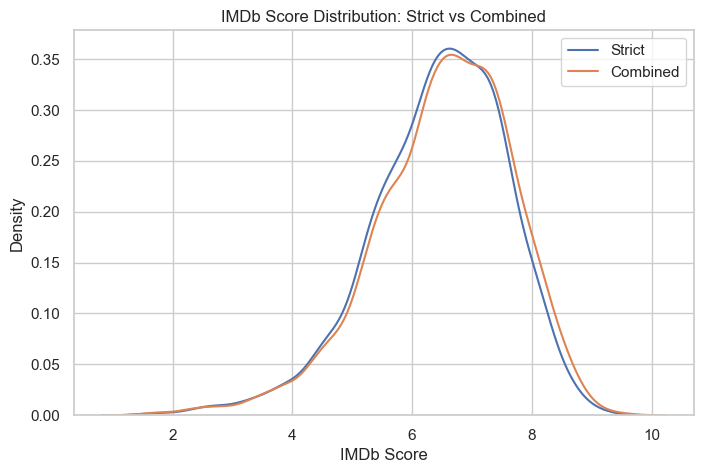

Score summary


,strict_mean,combined_mean,strict_median,combined_median
0,6.449136,6.533264,6.6,6.6


In [46]:
fig, ax = plt.subplots()
sns.kdeplot(strict["imdb_score"], label="Strict", ax=ax)
sns.kdeplot(combined["imdb_score"], label="Combined", ax=ax)
ax.set_title("IMDb Score Distribution: Strict vs Combined")
ax.set_xlabel("IMDb Score")
ax.legend()
plt.show()

print("Score summary")
display(pd.DataFrame({
    "strict_mean":   [strict["imdb_score"].mean()],
    "combined_mean": [combined["imdb_score"].mean()],
    "strict_median": [strict["imdb_score"].median()],
    "combined_median": [combined["imdb_score"].median()]
}))

2. Votes Distribution & Log-Votes

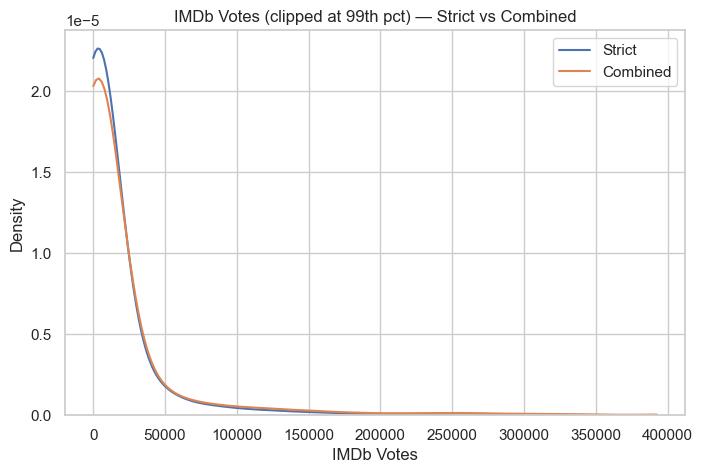

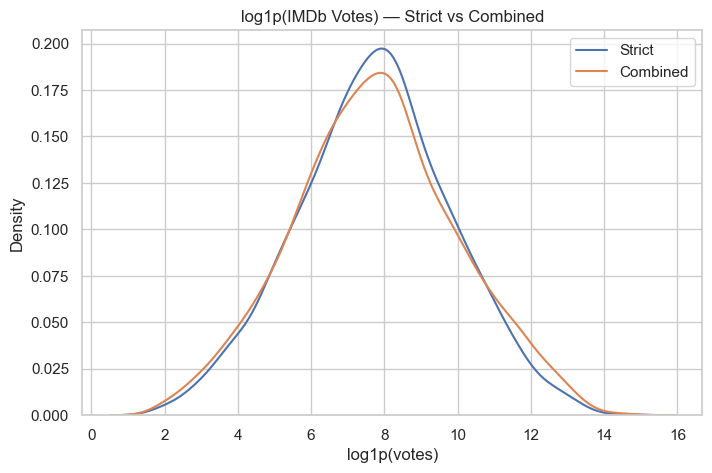

,strict_mean_votes,combined_mean_votes,strict_median_votes,combined_median_votes
0,18153.036518,23407.194988,2354.0,2279.0


In [47]:
fig, ax = plt.subplots()
sns.kdeplot(strict["imdb_votes"], label="Strict", ax=ax, clip=(0, np.percentile(strict["imdb_votes"], 99)))
sns.kdeplot(combined["imdb_votes"], label="Combined", ax=ax, clip=(0, np.percentile(combined["imdb_votes"], 99)))
ax.set_title("IMDb Votes (clipped at 99th pct) — Strict vs Combined")
ax.set_xlabel("IMDb Votes")
ax.legend()
plt.show()

fig, ax = plt.subplots()
sns.kdeplot(strict["imdb_votes_log1p"], label="Strict", ax=ax)
sns.kdeplot(combined["imdb_votes_log1p"], label="Combined", ax=ax)
ax.set_title("log1p(IMDb Votes) — Strict vs Combined")
ax.set_xlabel("log1p(votes)")
ax.legend()
plt.show()

display(pd.DataFrame({
    "strict_mean_votes":   [strict["imdb_votes"].mean()],
    "combined_mean_votes": [combined["imdb_votes"].mean()],
    "strict_median_votes":[strict["imdb_votes"].median()],
    "combined_median_votes":[combined["imdb_votes"].median()]
}))

Score/votes shapes are consistent.

	•	Scores cluster ~6–7 in both sets; combined has a tiny shift upward (likely more shows and shows have higher scores).
	•	Votes are extremely right-skewed; your log1p view looks near-normal → perfect for modeling.

3. Movies vs Shows: share & runtime clusters

,dataset,pct_show,pct_movie
0,Strict,28.985980,71.014020
1,Combined,35.617999,64.382001


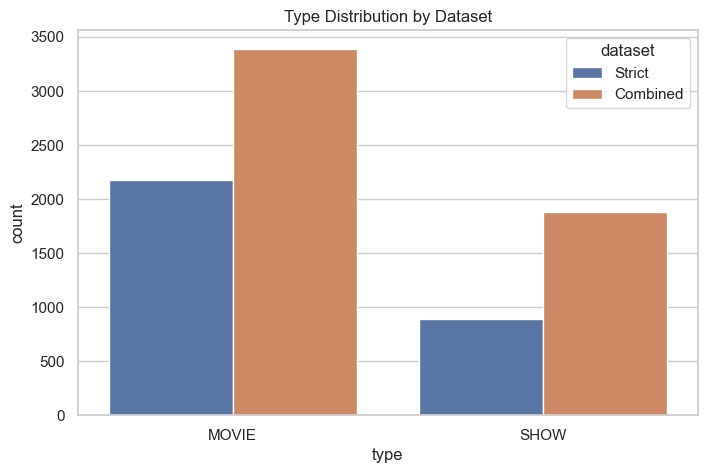

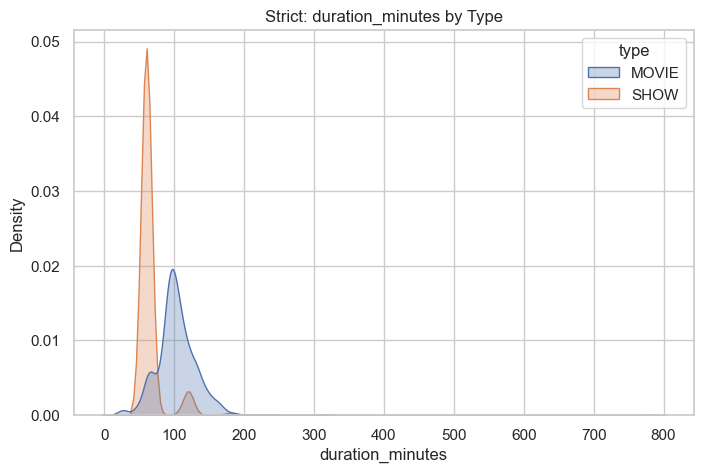

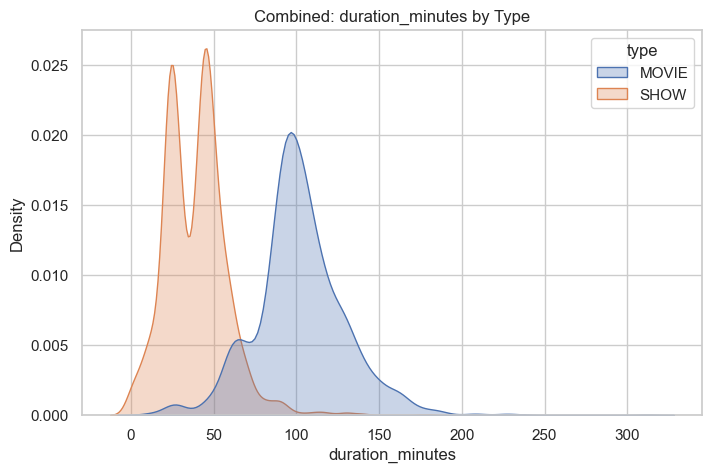

In [48]:
# 3) Movies vs Shows share
share = pd.DataFrame({
    "dataset": ["Strict", "Combined"],
    "pct_show": [
        strict["is_show"].mean()*100,
        combined["is_show"].mean()*100
    ],
    "pct_movie": [
        (1 - strict["is_show"]).mean()*100,
        (1 - combined["is_show"]).mean()*100
    ]
})
display(share)

fig, ax = plt.subplots()
sns.countplot(data=pd.concat([strict.assign(dataset="Strict"),
                              combined.assign(dataset="Combined")]),
              x="type", hue="dataset", ax=ax)
ax.set_title("Type Distribution by Dataset")
plt.show()

# runtime clusters by type
fig, ax = plt.subplots()
sns.kdeplot(data= strict, x="duration_minutes", hue="type", common_norm=False, ax=ax, fill=True, alpha=0.3, linewidth=1)
ax.set_title("Strict: duration_minutes by Type")
plt.show()

fig, ax = plt.subplots()
sns.kdeplot(data= combined, x="duration_minutes", hue="type", common_norm=False, ax=ax, fill=True, alpha=0.3, linewidth=1)
ax.set_title("Combined: duration_minutes by Type")
plt.show()

•	Your table shows ~29% shows (strict) vs ~36% shows (combined), **which explains the lower median runtimes in combined**. The KDEs by type confirm the classic ~45–60 min show vs ~90–120 min movie clusters.

4. Metadata Completeness (director, cast, country, genres)

,Strict % non-null,Combined % non-null
cast,90.446691,68.141257
country,100.000000,100.000000
desc_len,100.000000,100.000000
director,72.089990,47.921018
num_genres,100.000000,100.000000


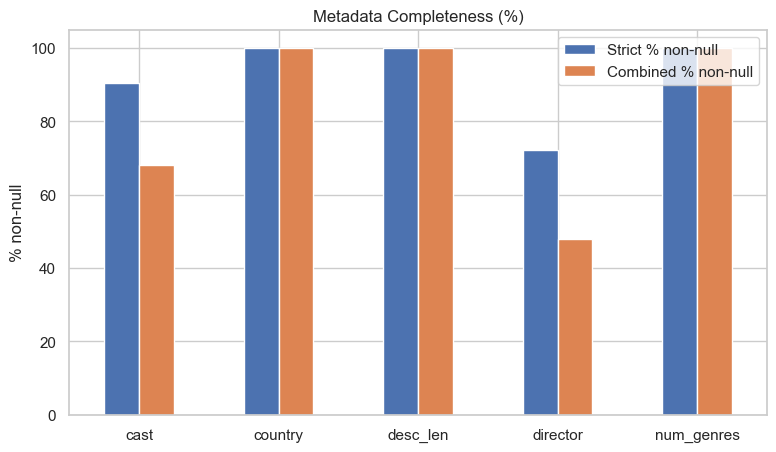

In [49]:
# 4) Metadata Completeness
def completeness(df, cols):
    return pd.Series({c: df[c].notna().mean()*100 for c in cols})

meta_cols = ["director","cast","country","num_genres","desc_len"]
comp = pd.DataFrame({
    "Strict % non-null": completeness(strict, meta_cols),
    "Combined % non-null": completeness(combined, meta_cols)
}).sort_index()
display(comp)

comp.plot(kind="bar", rot=0, title="Metadata Completeness (%)", figsize=(9,5))
plt.ylabel("% non-null")
plt.show()

•	director and cast non-null rates drop, which is expected: loose joins bring more titles but not always their meta. After your sync step you filled critical fields, so both sets are modelable, but strict is “cleaner”.

5. Genres: frequency & average score

,dataset,genre,count,avg_score
8,Combined,International Movies,1240,6.190968
6,Combined,Dramas,1067,6.369166
9,Combined,International TV Shows,722,7.142244
2,Combined,Comedies,711,5.943460
13,Combined,TV Dramas,451,7.219956
12,Combined,TV Comedies,348,6.989943
0,Combined,Action & Adventure,306,6.016993
10,Combined,Romantic Movies,297,6.090572
7,Combined,Independent Movies,296,6.344257
3,Combined,Crime TV Shows,279,7.237276


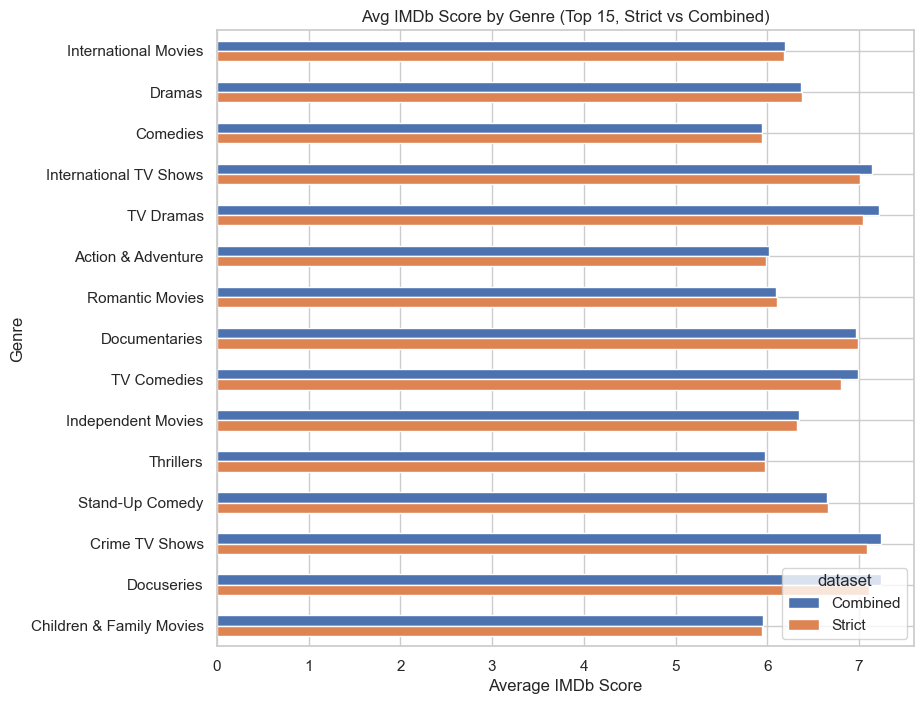

In [50]:
# 5) Genres frequency & average score
def explode_genres(df):
    # listed_in can be missing in combined strict+loose in some rows, guard it:
    li = df.get("listed_in")
    if li is None:
        return pd.DataFrame(columns=["genre","imdb_score","dataset"])
    # explode
    tmp = df[["imdb_score","listed_in"]].dropna().copy()
    tmp["listed_in"] = tmp["listed_in"].str.split(",")
    tmp = tmp.explode("listed_in")
    tmp["genre"] = tmp["listed_in"].str.strip()
    return tmp[["genre","imdb_score"]].dropna()

g_strict   = explode_genres(strict).assign(dataset="Strict")
g_combined = explode_genres(combined).assign(dataset="Combined")
g_all = pd.concat([g_strict, g_combined], ignore_index=True)

# top 15 genres by count (overall)
top_genres = (g_all.groupby("genre").size()
              .sort_values(ascending=False)
              .head(15)
              .index.tolist())

summary = (g_all[g_all["genre"].isin(top_genres)]
           .groupby(["dataset","genre"])
           .agg(count=("imdb_score","size"), avg_score=("imdb_score","mean"))
           .reset_index()
           .sort_values(["dataset","count"], ascending=[True,False]))

display(summary.head(30))

# viz avg score for top genres
pivot_avg = summary.pivot(index="genre", columns="dataset", values="avg_score").loc[top_genres]
pivot_avg.plot(kind="barh", title="Avg IMDb Score by Genre (Top 15, Strict vs Combined)", figsize=(9,8))
plt.xlabel("Average IMDb Score")
plt.ylabel("Genre")
plt.gca().invert_yaxis()
plt.show()

•	Top-15 genre averages are very close across datasets. Small shifts are composition, not a pipeline bug.

6. Country and Age Certification — distributions & score by group

In [51]:
def top_by_col(df, col, n=12):
    return (df[col].value_counts()
            .head(n)
            .index.tolist())

top_countries = top_by_col(strict, "country", 12)
top_ages      = top_by_col(strict, "age_certification", 8)

def mean_score_by(df, col, keep):
    tmp = df[df[col].isin(keep)]
    return tmp.groupby(col)["imdb_score"].mean().sort_values(ascending=False)

print("Mean score by Top Countries (Strict):")
display(mean_score_by(strict, "country", top_countries))

print("Mean score by Top Countries (Combined):")
display(mean_score_by(combined, "country", top_countries))

print("Mean score by Age Cert (Strict):")
display(mean_score_by(strict, "age_certification", top_ages))

print("Mean score by Age Cert (Combined):")
display(mean_score_by(combined, "age_certification", top_ages))

Mean score by Top Countries (Strict):


country
South Korea       7.331579
Japan             7.074490
United Kingdom    6.777647
Unknown           6.506098
United States     6.433939
Philippines       6.415000
Other             6.395055
Spain             6.339394
India             6.314081
France            6.221429
Canada            5.947500
Nigeria           5.873171
Name: imdb_score, dtype: float64

Mean score by Top Countries (Combined):


country
South Korea       7.284685
Japan             7.237778
United Kingdom    7.037762
United States     6.568087
Unknown           6.484935
Canada            6.474627
Spain             6.466667
France            6.414085
Philippines       6.410769
India             6.328419
Nigeria           5.936170
Name: imdb_score, dtype: float64

Mean score by Age Cert (Strict):


age_certification
TV-14      7.110145
TV-MA      6.926884
TV-PG      6.632895
PG-13      6.401136
R          6.297523
Unknown    6.284512
G          6.237097
PG         6.182278
Name: imdb_score, dtype: float64

Mean score by Age Cert (Combined):


age_certification
TV-14      7.262615
TV-MA      7.065909
TV-PG      6.916860
PG-13      6.445694
G          6.393333
R          6.326190
Unknown    6.273705
PG         6.212236
Name: imdb_score, dtype: float64

•	KR/JP a bit higher; TV-14/MA higher than G/PG. This is pattern, not causation.

7. Correlations (numeric) - Strict vs Combined

Correlation with imdb_score — Strict


imdb_score          1.000000
is_show             0.272315
imdb_votes_log1p    0.183905
imdb_votes          0.150042
desc_len            0.020940
is_classic          0.016057
num_genres          0.006926
release_year       -0.058929
duration_minutes   -0.095401
runtime            -0.118707
Name: imdb_score, dtype: float64

Correlation with imdb_score — Combined


imdb_score          1.000000
is_show             0.310083
imdb_votes_log1p    0.223570
imdb_votes          0.189954
is_classic          0.034474
num_genres          0.032393
desc_len            0.029324
release_year       -0.102952
duration_minutes   -0.158146
runtime            -0.158390
Name: imdb_score, dtype: float64

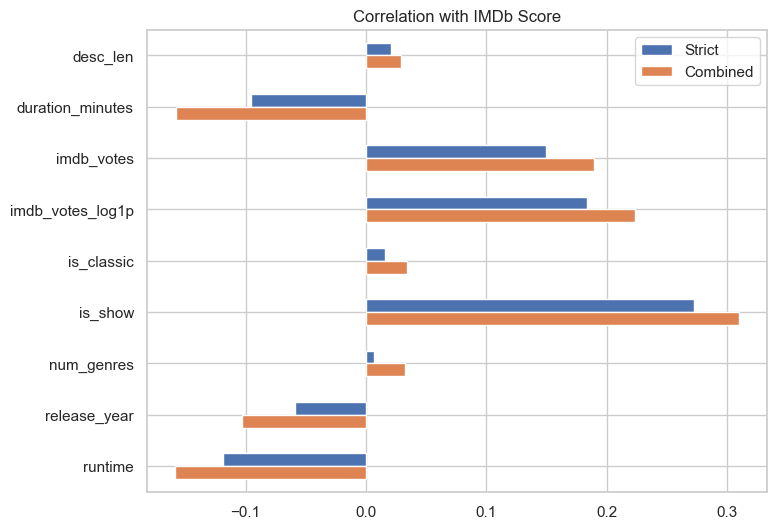

In [52]:
# 7) Correlations (numeric only)
num_cols = [
    "imdb_score","imdb_votes","imdb_votes_log1p",
    "runtime","duration_minutes","release_year",
    "desc_len","num_genres","is_show","is_classic"
]

corr_strict   = strict[num_cols].corr(numeric_only=True)["imdb_score"].sort_values(ascending=False)
corr_combined = combined[num_cols].corr(numeric_only=True)["imdb_score"].sort_values(ascending=False)

print("Correlation with imdb_score — Strict")
display(corr_strict)

print("Correlation with imdb_score — Combined")
display(corr_combined)

# side-by-side small bar chart
corr_df = pd.DataFrame({
    "Strict": corr_strict,
    "Combined": corr_combined
}).drop(index="imdb_score")

corr_df.plot(kind="barh", figsize=(8,6), title="Correlation with IMDb Score")
plt.gca().invert_yaxis()
plt.show()

•	is_show (~0.27–0.31) and log1p(votes) (~0.18–0.22) have the most signal. Runtime and release year are mildly negative. That’s normal for IMDb: scores don’t linearly depend on any single feature.

8. Simple “Does loose metadata help?” sanity checks

In [53]:
# 8) Does the extra metadata correlate with higher score?
# Define "got any extra meta" proxy for combined (rows where director/cast/country present)
combined["has_meta_any"] = combined[["director","cast","country"]].notna().any(axis=1)
strict["has_meta_any"]   = strict[["director","cast","country"]].notna().any(axis=1)

comp_meta = pd.DataFrame({
    "dataset":["Strict","Combined"],
    "pct_with_meta":[strict["has_meta_any"].mean()*100, combined["has_meta_any"].mean()*100],
    "avg_score_with_meta":[strict.loc[strict["has_meta_any"],"imdb_score"].mean(),
                           combined.loc[combined["has_meta_any"],"imdb_score"].mean()],
    "avg_score_without_meta":[strict.loc[~strict["has_meta_any"],"imdb_score"].mean(),
                              combined.loc[~combined["has_meta_any"],"imdb_score"].mean()]
})
display(comp_meta)

,dataset,pct_with_meta,avg_score_with_meta,avg_score_without_meta
0,Strict,100.0,6.449136,NaN
1,Combined,100.0,6.533264,NaN


All core features are present in all rows, because with meta/without meta is 100%/0% respectively.

### Export a model-ready table

1. Import libraries

In [54]:
import pandas as pd
from pathlib import Path

2. Paths

In [56]:
PROCESSED = Path("../data/processed")

3. Load datasets: strict clean and combined synced

In [57]:
strict = pd.read_csv(PROCESSED / "netflix_strict_clean.csv")
combined = pd.read_csv(PROCESSED / "netflix_combined_clean_synced.csv")

4. Helpers: Build model table

In [58]:
def build_model_table(df: pd.DataFrame,
                      one_hot_cols=("age_certification", "country"),
                      top_k_country=12):
    out = df.copy()

    # ---- basic numeric features (already prepared in earlier notebooks)
    num_keep = [
        "imdb_score",          # target for regression
        "imdb_votes",          # raw
        "imdb_votes_log1p",    # transformed
        "runtime",
        "duration_minutes",
        "release_year",
        "desc_len",
        "num_genres",
        "is_show",
        "is_classic",
    ]
    # keep only existing
    num_keep = [c for c in num_keep if c in out.columns]
    out = out[num_keep + ["title", "type"]]  # keep a couple for traceability

    # ---- classification target
    out["is_high"] = (out["imdb_score"] >= 7.0).astype(int)

    # ---- categorical encoding (small, interpretable)
    if "age_certification" in one_hot_cols and "age_certification" in df.columns:
        ac = pd.get_dummies(df["age_certification"], prefix="age", drop_first=False)
        out = pd.concat([out, ac], axis=1)

    if "country" in one_hot_cols and "country" in df.columns:
        # keep top-K frequent countries; others go to "Other"
        top_countries = (
            df["country"]
            .value_counts()
            .head(top_k_country)
            .index.tolist()
        )
        country_slim = df["country"].where(df["country"].isin(top_countries), "Other")
        c_enc = pd.get_dummies(country_slim, prefix="ctry", drop_first=False)
        out = pd.concat([out, c_enc], axis=1)

    # Optional: one-hot for 'type' if you prefer instead of is_show
    # type_d = pd.get_dummies(df["type"], prefix="type", drop_first=True)
    # out = pd.concat([out, type_d], axis=1)

    # Final sanity: drop rows with missing numeric essentials
    must_have = ["imdb_score", "imdb_votes_log1p", "duration_minutes", "release_year"]
    must_have = [c for c in must_have if c in out.columns]
    out = out.dropna(subset=must_have)

    return out

5. Model tables

In [59]:
strict_model   = build_model_table(strict)
combined_model = build_model_table(combined)

5. 
Save with plain NumPy-backed dtypes

6. 

In [69]:
# --- Final export: CSV + Parquet with robust dtype sanitization and engine fallback ---

from pathlib import Path
import os
import pandas as pd
from pandas.api.types import CategoricalDtype, PeriodDtype

# EXPECTS these DataFrames to already exist:
#   - strict_model
#   - combined_model

OUT_DIR = Path("../data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

STRICT_CSV  = OUT_DIR / "model_strict.csv"
COMBINED_CSV = OUT_DIR / "model_combined.csv"
STRICT_PARQUET  = OUT_DIR / "model_strict.parquet"
COMBINED_PARQUET = OUT_DIR / "model_combined.parquet"


def sanitize_for_parquet(df: pd.DataFrame) -> pd.DataFrame:
    """
    Make a copy with parquet-friendly dtypes:
    - Use numpy_nullable backend (avoid Arrow-backed extension types)
    - Convert boolean -> UInt8 (0/1/<NA>)
    - Convert category -> string
    - Convert Period -> string (critical for pyarrow)
    """
    out = df.copy()

    # Normalize to NumPy/nullable-NumPy dtypes (no pyarrow-backed dtypes)
    out = out.convert_dtypes(dtype_backend="numpy_nullable")

    for c in out.columns:
        dt = out[c].dtype

        # nullable boolean -> UInt8
        if str(dt) in ("boolean", "bool"):
            out[c] = out[c].astype("UInt8")

        # category -> plain string
        elif isinstance(dt, CategoricalDtype):
            out[c] = out[c].astype("string")

        # Period -> string (pyarrow can't handle pandas.period extension cleanly)
        elif isinstance(dt, PeriodDtype):
            out[c] = out[c].astype("string")

    return out


def write_parquet_with_fallback(df: pd.DataFrame, path: Path) -> bool:
    """
    Try pyarrow; if it fails, try fastparquet.
    Return True on success, False if both engines fail.
    """
    # remove stale file if created by a different engine earlier
    try:
        os.remove(path)
    except FileNotFoundError:
        pass

    # Always sanitize first
    clean = sanitize_for_parquet(df)

    # Try pyarrow
    try:
        clean.to_parquet(path, index=False, engine="pyarrow")
        # quick round-trip
        _ = pd.read_parquet(path, engine="pyarrow").head()
        print(f"[ok] Parquet (pyarrow): {path}")
        return True
    except Exception as e_pa:
        print(f"[warn] pyarrow failed: {e_pa}")

    # Fallback: fastparquet
    try:
        clean.to_parquet(path, index=False, engine="fastparquet")
        _ = pd.read_parquet(path, engine="fastparquet").head()
        print(f"[ok] Parquet (fastparquet): {path}")
        return True
    except Exception as e_fp:
        print(f"[warn] fastparquet failed: {e_fp}")
        print("[skip] Could not write parquet with either engine.")
        return False


# ---- Write CSVs (always) ----
strict_model.to_csv(STRICT_CSV, index=False)
combined_model.to_csv(COMBINED_CSV, index=False)
print(f"[ok] CSV: {STRICT_CSV}")
print(f"[ok] CSV: {COMBINED_CSV}")

# ---- Parquet (best-effort with fallback) ----
ok1 = write_parquet_with_fallback(strict_model, STRICT_PARQUET)
ok2 = write_parquet_with_fallback(combined_model, COMBINED_PARQUET)

print("\nSummary:")
print(f" - CSV strict:     {STRICT_CSV}")
print(f" - CSV combined:   {COMBINED_CSV}")
print(f" - Parquet strict: {'saved' if ok1 else 'skipped'} ({STRICT_PARQUET})")
print(f" - Parquet comb.:  {'saved' if ok2 else 'skipped'} ({COMBINED_PARQUET})")

[ok] CSV: ../data/processed/model_strict.csv
[ok] CSV: ../data/processed/model_combined.csv
[warn] pyarrow failed: A type extension with name pandas.period already defined
[ok] Parquet (fastparquet): ../data/processed/model_strict.parquet
[warn] pyarrow failed: A type extension with name pandas.period already defined
[ok] Parquet (fastparquet): ../data/processed/model_combined.parquet

Summary:
 - CSV strict:     ../data/processed/model_strict.csv
 - CSV combined:   ../data/processed/model_combined.csv
 - Parquet strict: saved (../data/processed/model_strict.parquet)
 - Parquet comb.:  saved (../data/processed/model_combined.parquet)
